In [ ]:
!pip install plotly
!pip install scikit-learn==1.2.1
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

In [1]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cellnet_simple/default/version_5/checkpoints/val_f1_macro_epoch=43_val_f1_macro=0.747.ckpt'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load model

In [4]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Classification performance

In [5]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

from utils import correct_labels

In [6]:
probas = estim.predict(estim.datamodule.test_dataloader())
y_pred = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [04:38<00:00,  2.46it/s]


In [7]:
assert y_pred.shape[0] == y_true.shape[0]

#### Overall performance

In [8]:
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

In [9]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.862288,0.862288,0.862288,8.622883e-01
macro avg,0.716558,0.804275,0.734993,1.403904e+06
weighted avg,0.889106,0.862288,0.867815,1.403904e+06


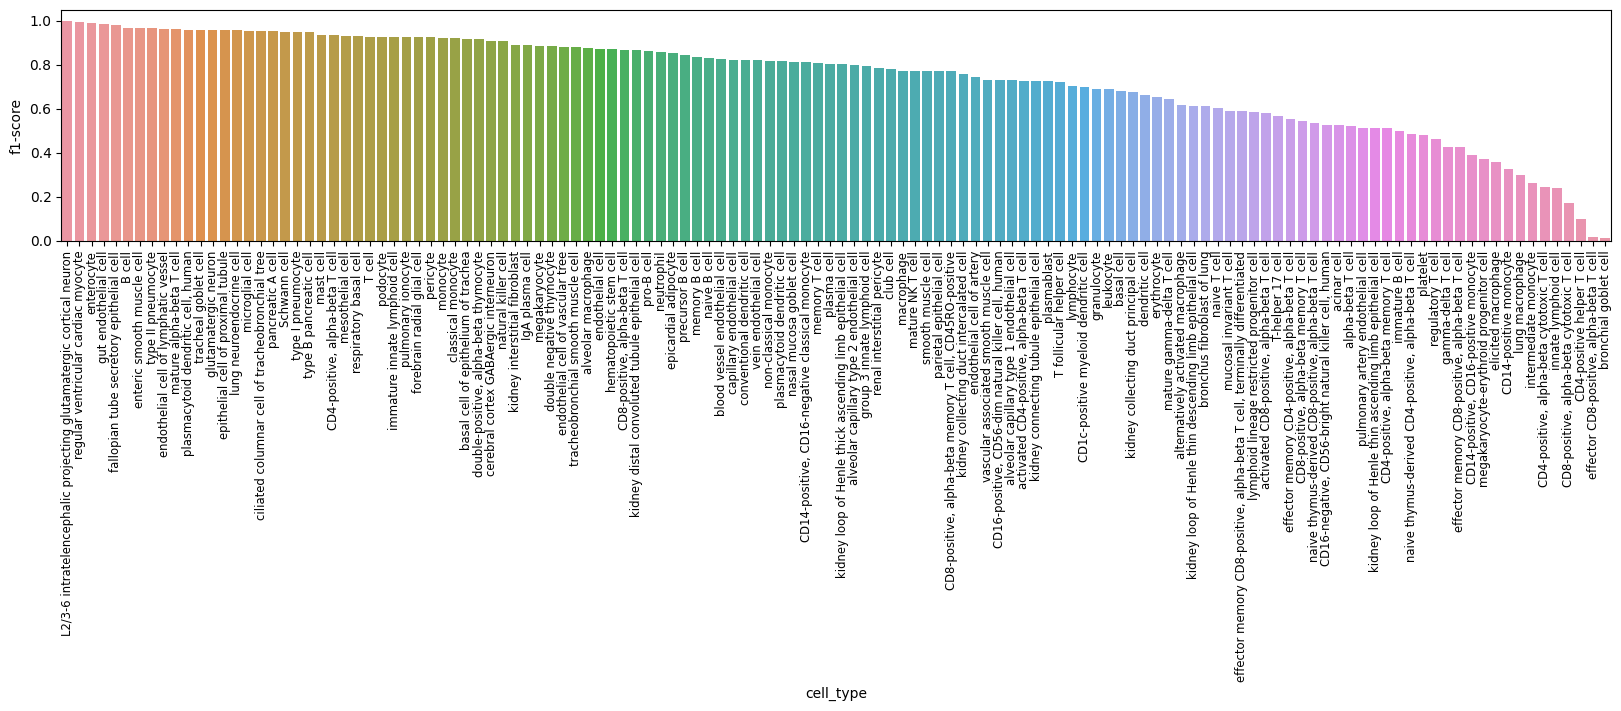

In [10]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');

#### Confustion matrix

In [11]:
c_matrix = confusion_matrix(y_true, y_pred_corr, normalize='true')

In [ ]:
px.imshow(
    c_matrix, 
    width=1000, height=1000,
    labels={'x': 'Predicted Label', 'y': 'True Label'},
    x=cell_type_mapping.label.tolist(), y=cell_type_mapping.label.tolist()
)

# Visualize predictions

In [18]:
import anndata
import scanpy as sc

## predictions vs true labels

Plot TSNE embedding (based on 64 PCA components of the input features) and super-impose true labels and predicted labels

In [16]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten()
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [19]:
sc.pp.subsample(adata, n_obs=200_000)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.tsne(adata, use_rep='X')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


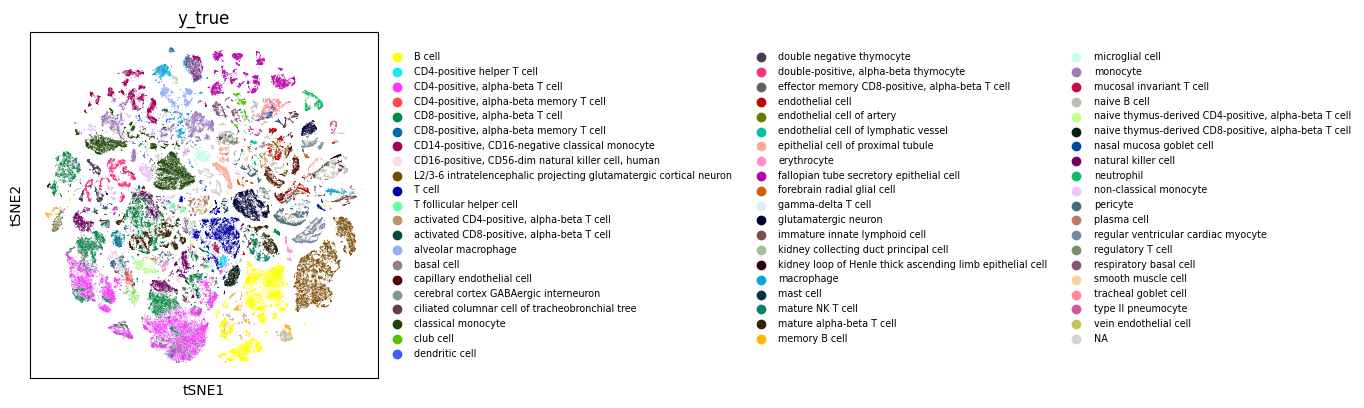

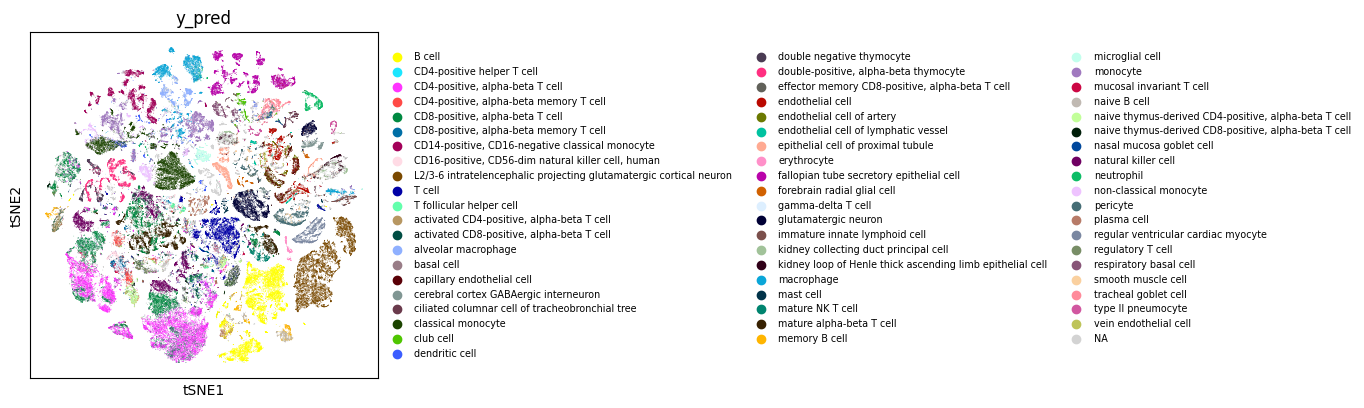

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


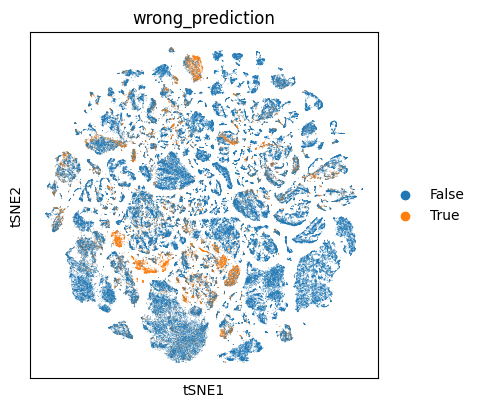

In [20]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata, color='wrong_prediction')

## Visualize learned features

Plot TSNE embedding (based on last layer of trained neural network) and super-impose true labels and predicted labels

In [21]:
# get feature embedding
estim.model.predict_bottleneck = True
x_emb = estim.predict(estim.datamodule.test_dataloader())
estim.model.predict_bottleneck = False

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [04:53<00:00,  2.34it/s]


In [22]:
adata_emb = anndata.AnnData(
    X=x_emb, 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten()
    })
)
adata_emb.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [23]:
sc.pp.subsample(adata_emb, n_obs=200_000)
# reduce to 64 dim before computing TSNE embedding
sc.pp.pca(adata_emb, n_comps=64)
sc.pp.neighbors(adata_emb)
sc.tl.tsne(adata_emb)

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


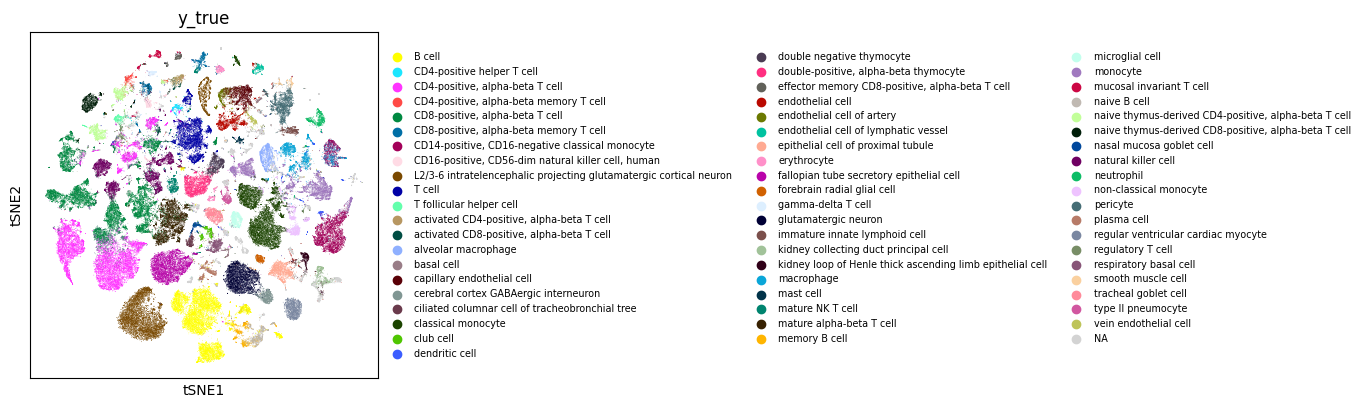

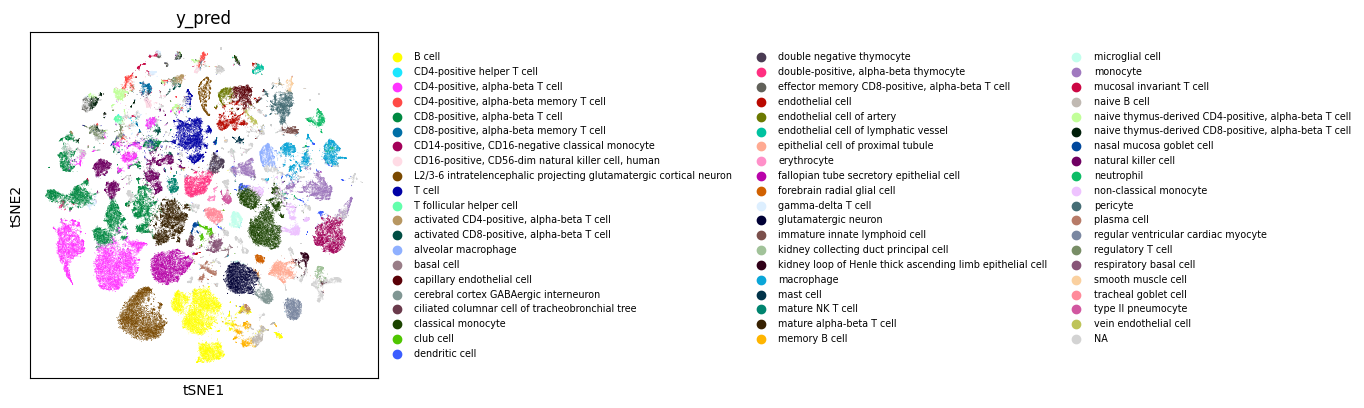

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


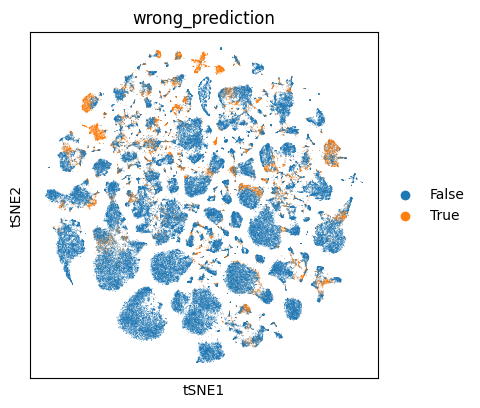

In [24]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata_emb.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata_emb.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_emb, color='wrong_prediction')